In [11]:
# COMP SCI 7319OL — Part C: Predictive Modeling for Aged Care Capacity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load preprocessed SA3-level aged care data
pivot_df = pd.read_excel("cleaned_CURF_file.xlsx")  

C:\Users\Hazim\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


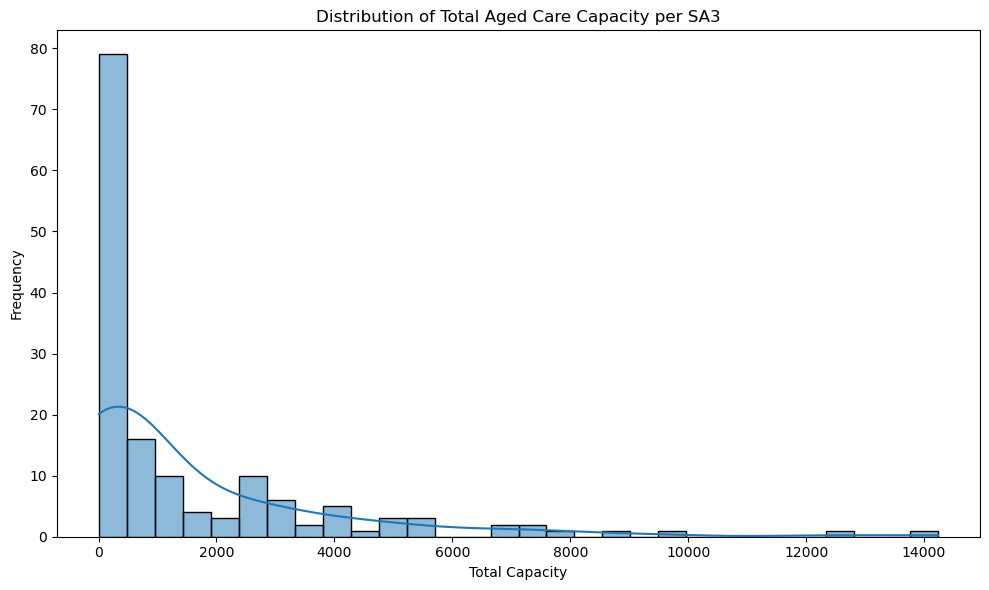

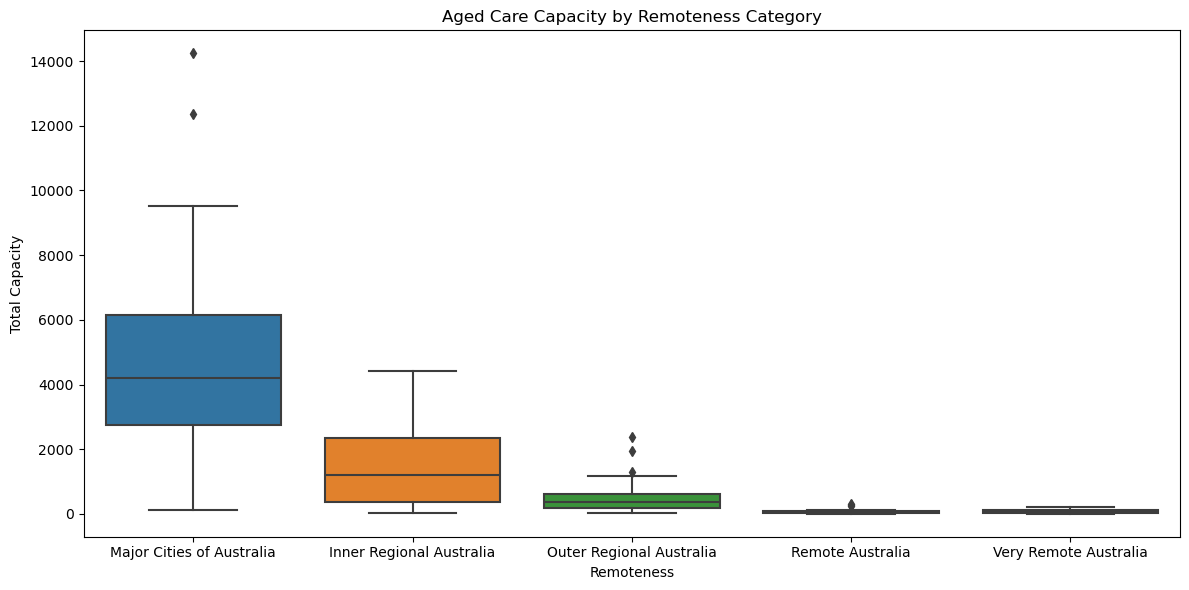

In [12]:
# 2. Exploratory Plots 
plt.figure(figsize=(10, 6))
sns.histplot(pivot_df["Total_Capacity"], bins=30, kde=True)
plt.title("Distribution of Total Aged Care Capacity per SA3")
plt.xlabel("Total Capacity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=pivot_df, x="Remoteness", y="Total_Capacity")
plt.title("Aged Care Capacity by Remoteness Category")
plt.xlabel("Remoteness")
plt.ylabel("Total Capacity")
plt.tight_layout()
plt.show()

In [13]:
# 3. Define features and target
X = pivot_df.drop(columns=["SA3_CODE", "SA3_NAME", "Total_Capacity"])
y = pivot_df["Total_Capacity"]

categorical_cols = ["Remoteness"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# 4. Preprocessing
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), numeric_cols),
    ("encode", OneHotEncoder(drop="first"), categorical_cols)
])

# 5. Model Candidates
models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {"alpha": [0.1, 1.0, 10.0]}
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {"n_estimators": [50, 100], "max_depth": [5, 10]}
    }
}

In [14]:
# 6. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 7. Train Models & Evaluate
results = []
best_models = {}

for name, cfg in models.items():
    pipeline = Pipeline([
        ("pre", preprocessor),
        ("model", cfg["model"])
    ])
    
    grid = GridSearchCV(
        pipeline,
        param_grid={f"model__{k}": v for k, v in cfg["params"].items()},
        cv=3,
        scoring="r2",
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred)
    })
    
    best_models[name] = grid

results_df = pd.DataFrame(results)
print("Model Comparison Table")
print(results_df)

Model Comparison Table
               Model                                        Best Params  \
0  Linear Regression                                                 {}   
1   Ridge Regression                              {'model__alpha': 0.1}   
2      Random Forest  {'model__max_depth': 10, 'model__n_estimators'...   

            MAE          RMSE  R2 Score  
0  9.070232e-13  1.335623e-12  1.000000  
1  1.934042e+00  3.902684e+00  0.999997  
2  9.315610e+01  2.298006e+02  0.988969  


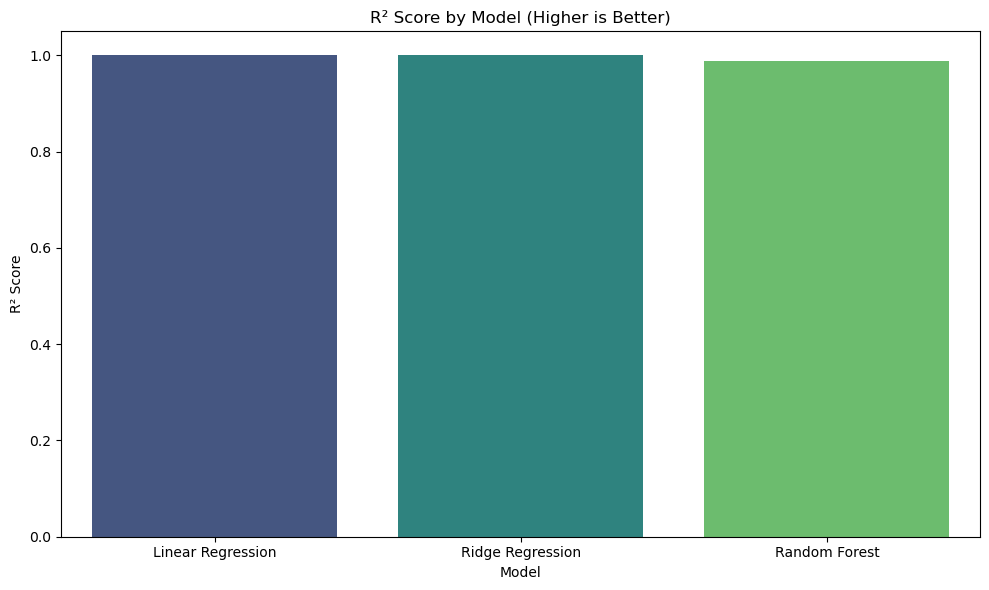

In [15]:
# 8. Bar Plot — Model Performance Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="R2 Score", data=results_df, palette="viridis")
plt.title("R² Score by Model (Higher is Better)")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

In [16]:
# 9. Visualise Best Model Predictions
best_model_name = results_df.sort_values(by="R2 Score", ascending=False).iloc[0]["Model"]
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test)

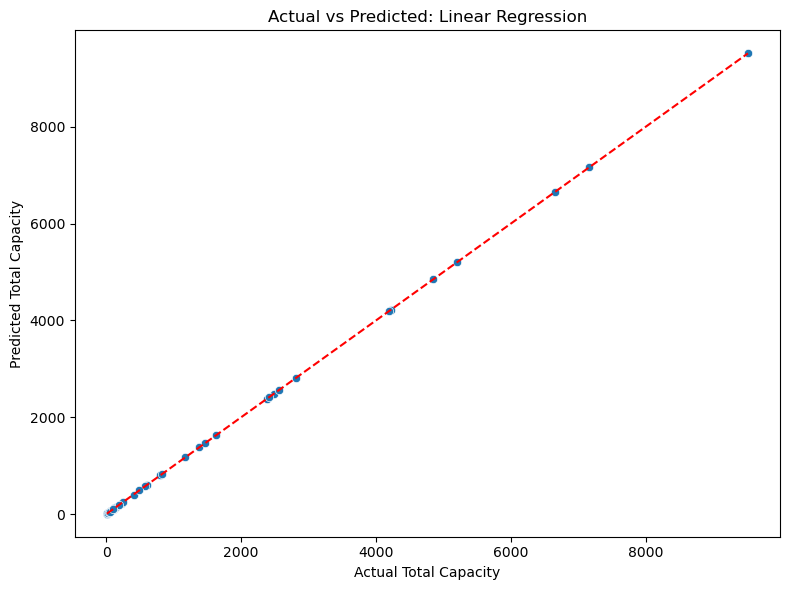

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Actual vs Predicted: {best_model_name}")
plt.xlabel("Actual Total Capacity")
plt.ylabel("Predicted Total Capacity")
plt.tight_layout()
plt.show()

C:\Users\Hazim\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


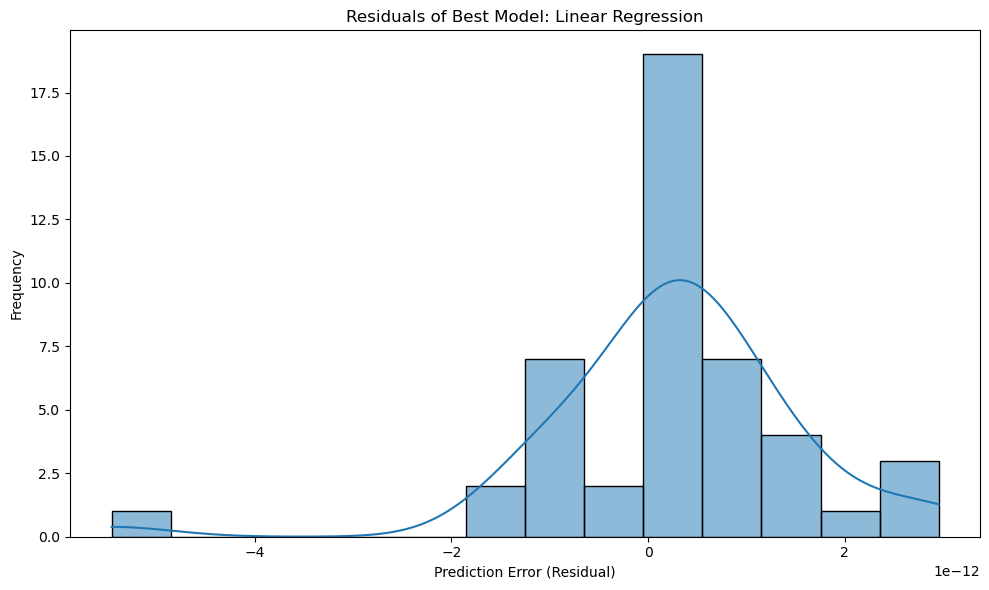

In [18]:
# 10. Residual Plot (Error Distribution)
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title(f"Residuals of Best Model: {best_model_name}")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()